# Installation & Setup

In [87]:
#this cell only needs to be run once for every new run time
# Deleted a few things from code from Cynthia
!pip install transformers[torch,sentencepiece] torch datasets -U --quiet

In [88]:
# Deleted a few things from prior code

#important relevant modeling libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Code copied from Cynthia
from datasets import Dataset

# Code copied from https://huggingface.co/learn/nlp-course/chapter0/1?fw=pt.
import transformers

from transformers import AutoModel, AutoTokenizer, AddedToken
# Code copied from: https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
from tqdm.auto import tqdm

In [89]:
#copy this block over for all successive model iterations
import pandas as pd
import os
import json
import numpy as np
import ast

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Code may copy from lesson_4_BERT.ipynb

model_name = "bert-base-uncased"
bert_model = AutoModel.from_pretrained(model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data processing for model specifically

In [91]:
# Changing max length to 512 as 512 is the maximium for BERT (copied from: https://huggingface.co/learn/nlp-course/)
max_length = 512

In [92]:
# Function to pad or truncate the key_timing data
def pad_or_truncate(array):
    if len(array) < max_length:
        # If the array is shorter than the desired length, pad it with zeros.
        # You can use np.pad to add zeros at the end of the array.
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=(0.0))
    else:
        # If the array is longer than the desired length, truncate it.
        # You can use array slicing to keep only the first 'desired_length' elements.
        return array[:max_length]

# FUnction to ONLY truncate the key_timing data
def truncate(array):
  if len(array) < max_length:
    return array
  else:
    return array[:max_length]


# Function to convert a string to a Python list
def string_to_list(input_string):
    return ast.literal_eval(input_string)

In [93]:
######################## READ IN DATA ###################################################################################################
data_path = '/content/drive/My Drive/266 Assignments/266 Final Project'
files = os.listdir(data_path)
files = [x for x in files if '.csv' in x]

filt_df = pd.read_csv(os.path.join(data_path, files[files.index('cleaned_data.csv')]))

#do some data cleanup to ensure timing sequence is in right data format
filt_df['timing_sequence'] = filt_df['timing_sequence'].apply(string_to_list)
filt_df['timing_sequence'] = filt_df['timing_sequence'].apply(pad_or_truncate)


In [94]:
######################## IMPORT SPECIAL TOKENS ############################################################################################
json_file = os.path.join(data_path, "token_map.json")
with open(json_file, 'r') as json_file:
    charbert_token_map = json.load(json_file)

added_tokens = [AddedToken(token) for token in charbert_token_map.values()]
# added_tokens

In [95]:
# Add the special tokens from charbert_token_map to the tokenizer's vocabulary
# Looks like [unused1] to [unused26] are present for "bert-base-uncased" too: https://huggingface.co/bert-base-uncased/blob/main/vocab.txt
bert_tokenizer.add_tokens(added_tokens)

26

In [96]:
# must also add special tokens to the model
bert_model.resize_token_embeddings(len(bert_tokenizer))

Embedding(30522, 768, padding_idx=0)

In [97]:
#resample the data to balance it exactly 50-50 HC-PD

#separate the classes
class_1 = filt_df[filt_df['diagnosis'] == 1]
class_0 = filt_df[filt_df['diagnosis'] == 0]

#downsample the majority class
class_0_down = resample(class_0, replace=False, n_samples = len(class_1), random_state=42)

# Combine minority class with downsampled majority class
balanced_data = pd.concat([class_1, class_0_down])
len(balanced_data)

2940

In [98]:
#split the data
# Split the data into training, validation, and test sets
X = balanced_data[['key_sequence', 'timing_sequence']]
y = balanced_data['diagnosis']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [99]:
# Put data into a pandas dataframe to then load into a hugging face dataset object
# Code and idea copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
train_df = X_train
train_df['labels']=y_train
train_df.columns = ['response', 'time_seq','labels']

# Code copied from above
# Made a df of our validation data
val_df = X_val
val_df['labels']=y_val
val_df.columns = ['response', 'time_seq','labels']

test_df = X_test
test_df['labels']=y_test
test_df.columns = ['response', 'time_seq','labels']

In [100]:
# Code copied from https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
# Make a hugging face dataset object from the pandas df we just made
train_dataset = Dataset.from_pandas(train_df)

# Code copied from above
# Make a validation Dataset
val_dataset = Dataset.from_pandas(val_df)

# Code copied from above
# Make a test Dataset
test_dataset = Dataset.from_pandas(test_df)

In [101]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt and prior code above (likely from BERT lesson notebooks/assignment)
# Code also copied from https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt
# Create a tokenize function we'll use to tokenize the key sequences in the dataset
def tokenize_func(a):
  return bert_tokenizer(
    a['response'],
    # Changing padding to max_length, copied from https://huggingface.co/learn/nlp-course/chapter2/6?fw=pt
    # Getting rid of padding here (copying from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt).
    # It's more efficient to do padding at the batch level later on (use "dynamic padding") according to the above source
    padding='max_length',
    # Trunction true should truncate to max length: Copied from https://huggingface.co/docs/transformers/main_classes/tokenizer
    truncation=True,
    # Testing a shorter max length based on https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt
    # Getting rid of max length from here to, copying from: https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
    # Reinstating max length since got an error
    max_length=max_length,
    # Getting rid of return tensors so that this code runs! Gave an erron when it was here
    # return_tensors='pt'
    )

In [102]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
# Tokenize the key sequences which will add the results to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_func, batched=True)

# Code copied from above
# Tokenize validation dataset
tokenized_val_dataset = val_dataset.map(tokenize_func, batched=True)

# Code copied from above
# Tokenize test dataset
tokenized_test_dataset = test_dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/2058 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

In [103]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Get rid of all columns in our dataset that our model won't accept
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['response', '__index_level_0__',])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['response', '__index_level_0__',])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['response', '__index_level_0__',])

In [104]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set output to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

In [105]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Check column names align with what model expects
tokenized_train_dataset.column_names

['time_seq', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [106]:
# Code copied from https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt
  # Copied from https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt:
  # "... apply the correct amount of padding to the items of the dataset we want to batch together.
  # ... such a function via DataCollatorWithPadding. It takes a tokenizer when you instantiate it
   #(to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs)
# Setting max length, and padding - copied from https://huggingface.co/docs/transformers/main_classes/data_collator
# Errored out, so got rid of these
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [107]:
#make data loaders
batch_size = 8


train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_val_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

In [108]:
# Check of Dataloader copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'time_seq': torch.Size([8, 512]),
 'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

# BERT Model + LSTM WITH Key Timings

In [109]:
# Additional features input size
additional_features_size = max_length #last dimension of combined features tensor

In [110]:
# # Code copied from above with architecture changed

# class CustomModel(nn.Module):
#     def __init__(self, bert_model, additional_features_size, num_labels=2):
#         super(CustomModel, self).__init__()
#         self.bert_model = bert_model
#         self.additional_features_size = additional_features_size

#         # # Add LSTM layers for additional features
#         # self.lstm1 = nn.LSTM(input_size=768, hidden_size=512, batch_first=True) #BERT alone
#         # self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
#         # self.lstm3 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
#         # self.lstm4 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
#         # self.lstm5 = nn.LSTM(input_size=(64+additional_features_size), hidden_size=32, batch_first=True)

#         # # Output layer for binary classification
#         # self.classifier = nn.Linear(32, num_labels)

#     def forward(self, input_ids, attention_mask, token_type_ids, time_seq):
#         # BERT forward pass
#         bert_outputs = self.bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
#         logits = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token



#         # # LSTM forward pass for additional features
#         # lstm_outputs1, _ = self.lstm1(bert_cls)
#         # lstm_outputs2, _ = self.lstm2(lstm_outputs1)
#         # lstm_outputs3, _ = self.lstm3(lstm_outputs2)
#         # lstm_outputs4, _ = self.lstm4(lstm_outputs3)

#         # # Concatenate BERT CLS and LSTM outputs
#         # combined_features = torch.cat((lstm_outputs4, time_seq), dim=1)

#         # lstm_outputs5, _ = self.lstm5(combined_features)

#         # # Classification layer
#         # logits = self.classifier(lstm_outputs5)

#         return logits

In [111]:
# class CustomModel(nn.Module):
#     def __init__(self, bert_model, additional_features_size, num_labels=2):
#         super(CustomModel, self).__init__()
#         self.bert_model = bert_model
#         self.additional_features_size = additional_features_size

#         # Add LSTM layers for additional features
#         self.lstm1 = nn.LSTM(input_size=additional_features_size, hidden_size=64, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
#         self.lstm3 = nn.LSTM(input_size=32, hidden_size=16, batch_first=True)


#         # Output layer for binary classification
#         self.classifier = nn.Linear(16, num_labels)  # 768 is the size of the CharBERT embeddings

#     def forward(self, input_ids, attention_mask):
#         # BERT forward pass
#         bert_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
#         # print(len(charbert_outputs))
#         bert_embeddings = bert_outputs[0][:,0,:] # Copying from above (see corresponding sources), getting the CLS token

#         # # Concatenate BERT cls and time sequence
#         # combined_features = torch.cat((bert_embeddings, time_seq), dim=1)

#         # print(f"combined features: {combined_features.shape}")

#         print(f"bert embedding: {bert_embeddings.shape}")
#         # print(f"time seq: {time_seq.shape}")

#         # LSTM forward pass for additional features
#         lstm_outputs1, _ = self.lstm1(bert_embeddings)
#         lstm_outputs2, _ = self.lstm2(lstm_outputs1)
#         lstm_outputs3, _ = self.lstm3(lstm_outputs2)
#         # last_lstm_output = lstm_outputs[:, -1, :].unsqueeze(1)


#         # # Concatenate BERT cls and time sequence
#         # combined_features = torch.cat((bert_embeddings, lstm_outputs3), dim=1)

#         print(f"output of last LSTM: {lstm_outputs3.shape}")

#         # Classification layer
#         logits = self.classifier(lstm_outputs3)

#         print(f"logits: {logits.shape}")

#         return logits

In [112]:
# Instantiate the custom model
model = bert_model

In [113]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set up to use the GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

## Train the model

In [114]:
# Define helper functions to calculate accuracy
# Code and comments copied from https://medium.com/p/a70372764432

def get_accuracy(model, dataloader):
  '''puts model in evaluation mode then gets accuracy'''
  model = model.eval()
  correct = 0
  total_examples = 0
  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      logits = model(input_ids = batch['input_ids'].to(device), # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device),
        token_type_ids = batch['token_type_ids'].to(device),
        # time_seq = batch['time_seq'].to(device)
        )
    predictions =  torch.argmax(logits[0][:,0,:], dim=1) # Copied from https://pytorch.org/docs/stable/generated/torch.argmax.html
    labels = batch['labels'].to(device)
    labels = labels.view(predictions.shape)
    comparison = labels == predictions
    correct += torch.sum(comparison)
    total_examples += len(comparison)

  return correct / total_examples

In [115]:
num_epochs = 1

In [116]:
# Code copied from Cynthia
learning_rate=5e-5
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [117]:
# Code copied from Cynthia
# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

In [118]:
# Copied from https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt
# Set up to get a progress bar
num_train_steps = num_epochs*len(train_dataloader)

In [119]:
# Code copied from Cynthia
# Changes I've made may copy from throughout this course: https://huggingface.co/learn/nlp-course**
# May also copy from lesson_4_BERT.ipynb
# Training loop

progress_bar = tqdm(range(num_train_steps))

for epoch in range(num_epochs):
    model = model.train()
    train_loss = 0.0
    val_loss = 0.0
    # Training loop
    for batch in train_dataloader:

        input_ids = batch['input_ids'].to(device) # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        # time_seq = batch['time_seq'].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask) #, time_seq=time_seq)

        loss = criterion(outputs[0][:,0,:], batch["labels"].to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    train_accuracy = get_accuracy(model,train_dataloader)
    val_accuracy = get_accuracy(model,val_dataloader)

    # Code copies from https://medium.com/p/a70372764432 and above (see corresponding sources)
    # Evaluation loop to get validation loss
    model = model.eval()
    for batch in val_dataloader:

        input_ids = batch['input_ids'].to(device) # Copying from https://discuss.pytorch.org/t/expected-all-tensors-to-be-on-the-same-device-but-found-at-least-two-devices-cuda-0-and-cpu/98537/2, putting input data to the same device as the model
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        # time_seq = batch['time_seq'].to(device)

        with torch.no_grad():
          outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask) #, time_seq=time_seq)
          loss = criterion(outputs[0][:,0,:], batch["labels"].to(device))
          val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}  Train Accuracy: {train_accuracy:.4f}  Val Loss: {avg_val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")

  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 1/1: Train Loss: 1.0570  Train Accuracy: 0.5068  Val Loss: 0.7090  Val Accuracy: 0.5306


In [120]:
#modified get predictions function
def get_predictions(model, dataloader):
    model = model.eval()
    predictions_list = []
    true_labels_list = []

    for batch in dataloader:
        with torch.inference_mode():
            logits = model(input_ids=batch['input_ids'].to(device),
                           attention_mask=batch['attention_mask'].to(device),
                           token_type_ids=batch['token_type_ids'].to(device))

        predictions = torch.argmax(logits[0][:, 0, :], dim=1)
        predictions = list(predictions.cpu().numpy())
        true_labels = list(batch['labels'].cpu().numpy())  # Replace 'labels' with your true labels key

        predictions_list.extend(predictions)
        true_labels_list.extend(true_labels)

    return predictions_list, true_labels_list

In [121]:
# Code copied from above (see corresponding sources)
# Get probs for AUC calculation
def get_probs(model, dataloader):
    model = model.eval()
    probs_list = []
    true_labels_list = []

    for batch in dataloader:
        with torch.inference_mode():
            logits = model(input_ids=batch['input_ids'].to(device),
                           attention_mask=batch['attention_mask'].to(device),
                           token_type_ids=batch['token_type_ids'].to(device),
                          #  time_seq = batch['time_seq'].to(device))
            )

        softmax = nn.Softmax(dim=1) # Copied from https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
        probs = softmax(logits[0][:, 0, :])

        probs = list(probs.cpu().numpy())

        true_labels = list(batch['labels'].cpu().numpy())  # Replace 'labels' with your true labels key

        for prob in probs:
          probs_list.append(prob[1])
        true_labels_list.extend(true_labels)

    return probs_list, true_labels_list

In [122]:
bert_lstm_val_predictions, true_val_labels = get_predictions(model, val_dataloader)

In [123]:
# Now let's evaluate the model (code copied from prior notebook)

accuracy_val = accuracy_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
precision_val = precision_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
recall_val = recall_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))
f1_val = f1_score(np.array(true_val_labels), np.array(bert_lstm_val_predictions))

print("Accuracy: ", accuracy_val)
print("Precision: ", precision_val)
print("Recall: ", recall_val)
print("F1-Score: ", f1_val)

Accuracy:  0.5306122448979592
Precision:  1.0
Recall:  0.018957345971563982
F1-Score:  0.0372093023255814


In [124]:
bert_lstm_test_predictions, true_test_labels = get_predictions(model, test_dataloader)

In [125]:
bert_lstm_test_probs, true_test_labels_for_probs = get_probs(model, test_dataloader)

In [126]:
# Now let's evaluate the model (code copied from prior notebook)

accuracy_test = accuracy_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
precision_test = precision_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
recall_test = recall_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
f1_test = f1_score(np.array(true_test_labels), np.array(bert_lstm_test_predictions))
auc_test = roc_auc_score(np.array(true_test_labels_for_probs), np.array(bert_lstm_test_probs))

print("Accuracy: ", accuracy_test)
print("Precision: ", precision_test)
print("Recall: ", recall_test)
print("F1-Score: ", f1_test)
print("AUC: ", auc_test)

Accuracy:  0.4671201814058957
Precision:  0.0
Recall:  0.0
F1-Score:  0.0
AUC:  0.5264511464573436


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


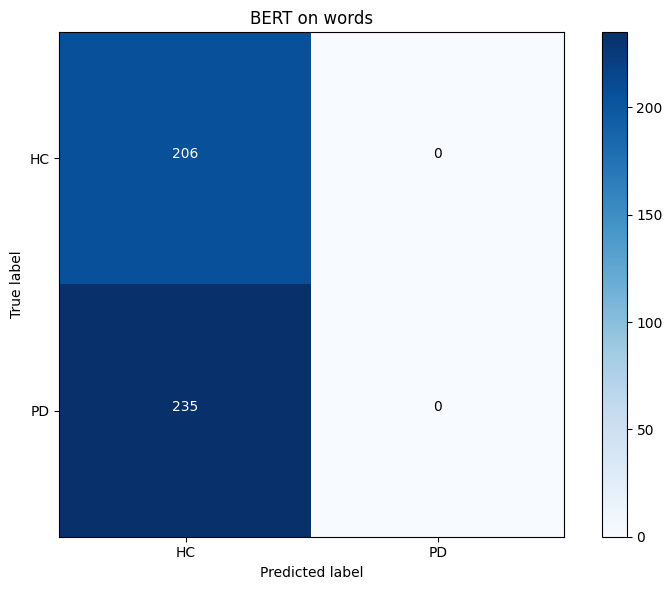

In [127]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

name = "BERT on words"
# Compute confusion matrix
cm = confusion_matrix(true_test_labels, bert_lstm_test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(name)
plt.colorbar()

classes = ['HC', 'PD']  # Change these labels according to your classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [128]:
#save the confusion matrix

file_name = f"confusion_matrix_{name}.png"
plt.savefig(os.path.join(data_path, file_name))

<Figure size 640x480 with 0 Axes>

In [129]:
import csv
from datetime import datetime

def write_metrics_to_csv(filename, metrics):
    try:
        with open(filename, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=metrics.keys())
            if file.tell() == 0:
              writer.writeheader()  # Write header if the file is empty

            writer.writerow(metrics)
    except IOError:
        print("Error writing to file")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

metrics = {
    "model name": name,
    "timestamp": timestamp,
    "accuracy": accuracy_test,
    "precision": precision_test,
    "recall": recall_test,
    "f1": f1_test,
    "auc": auc_test
}

# Write the metrics to a CSV file
write_metrics_to_csv(os.path.join(data_path, "metrics.csv"), metrics)